In [211]:
import cv2
from google.colab.patches import cv2_imshow
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border

In [212]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import torch.functional as F

print("[INFO] Loading modules")

class DigitRecognizer(nn.Module):
    def __init__(self, width=28, height=28, depth=1, classes=10):
        super(DigitRecognizer, self).__init__()

        # Feature extraction backbone
        self.features = nn.Sequential(
            # Block 1: 28×28 → 14×14
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),  # ← Changed
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),  # ← Changed
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            # Block 2: 14×14 → 7×7
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),  # ← Changed
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),  # ← Changed
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            # Block 3: 7×7 → 3×3 (with adaptive pooling to 4×4)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),  # ← Changed
            nn.AdaptiveAvgPool2d((4, 4))
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(128 * 4 * 4, 256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),  # ← Changed
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),  # ← Changed
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Feature extraction
        x = self.features(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Classification
        x = self.classifier(x)

        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            output = self.forward(x)
            _, predicted = torch.max(output.data, 1)
        return predicted

init_lr = 1e-3
Epochs = 20
BS = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"[INFO] Using device: {device}")

print("[INFO] accessing MNIST...")
data = np.load('mnist.npz')
print(data.keys())
trainData = np.concatenate((data['x_train'], data['x_test']))
trainLabels = np.concatenate((data['y_train'],data['y_test']))
testData = data['x_test']
testLabels = data['y_test']

trainData = trainData.reshape((trainData.shape[0], 1, 28, 28))
testData = testData.reshape((testData.shape[0], 1, 28, 28))

trainData = trainData.astype("float32") / 255.0
testData = testData.astype("float32") / 255.0


# Convert to binary - BEST FOR MNIST
trainData_binary = (trainData > 0.5).astype("float32")
testData_binary = (testData > 0.5).astype("float32")

# le = LabelBinarizer()
# trainLabels = le.fit_transform(trainLabels)
# testLabels = le.transform(testLabels)

trainData = torch.FloatTensor(trainData_binary)
trainLabels = torch.LongTensor(trainLabels)
testData = torch.FloatTensor(testData_binary)
testLabels = torch.LongTensor(testLabels)

train_dataset = TensorDataset(trainData, trainLabels)
test_dataset = TensorDataset(testData, testLabels)

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

print("[INFO] compiling model...")
model = DigitRecognizer(width=28, height=28, depth=1, classes=10)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = init_lr)

criterion = nn.CrossEntropyLoss()


print("[INFO] training network...")
train_losses = []
val_accuracies = []

for epoch in range(Epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for b_idx, (data,target) in enumerate(train_loader):
        data,target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()

    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val
    avg_loss = running_loss / len(train_loader)

    train_losses.append(avg_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{Epochs}], Loss: {avg_loss:.4f}, '
            f'Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')


[INFO] Loading modules
[INFO] Using device: cuda
[INFO] accessing MNIST...
KeysView(NpzFile 'mnist.npz' with keys: x_test, x_train, y_train, y_test)
[INFO] compiling model...
[INFO] training network...
Epoch [1/20], Loss: 0.3127, Train Acc: 91.05%, Val Acc: 98.29%
Epoch [2/20], Loss: 0.0849, Train Acc: 97.46%, Val Acc: 99.13%
Epoch [3/20], Loss: 0.0680, Train Acc: 97.93%, Val Acc: 99.27%
Epoch [4/20], Loss: 0.0557, Train Acc: 98.33%, Val Acc: 99.34%
Epoch [5/20], Loss: 0.0495, Train Acc: 98.51%, Val Acc: 99.21%
Epoch [6/20], Loss: 0.0471, Train Acc: 98.58%, Val Acc: 99.53%
Epoch [7/20], Loss: 0.0436, Train Acc: 98.69%, Val Acc: 99.52%
Epoch [8/20], Loss: 0.0400, Train Acc: 98.81%, Val Acc: 99.63%
Epoch [9/20], Loss: 0.0374, Train Acc: 98.88%, Val Acc: 99.73%
Epoch [10/20], Loss: 0.0364, Train Acc: 98.89%, Val Acc: 99.75%
Epoch [11/20], Loss: 0.0332, Train Acc: 98.97%, Val Acc: 99.75%
Epoch [12/20], Loss: 0.0324, Train Acc: 98.98%, Val Acc: 99.77%
Epoch [13/20], Loss: 0.0306, Train Acc:

In [213]:
# Save the model
print("[INFO] saving digit model...")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model.pth')

print("[INFO] Model saved as model.pth")

[INFO] saving digit model...
[INFO] Model saved as model.pth


In [214]:
# Evaluate the network
print("[INFO] evaluating network...")
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        #print(data.shape)
        data, target = data.to(device), target.to(device)
        predicted = model.predict(data)
        #print(predicted.shape)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        #break
print(classification_report(
    all_targets,
    all_predictions,
    target_names=[str(x) for x in le.classes_]))



[INFO] evaluating network...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       1.00      1.00      1.00       892
           6       1.00      1.00      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      1.00      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



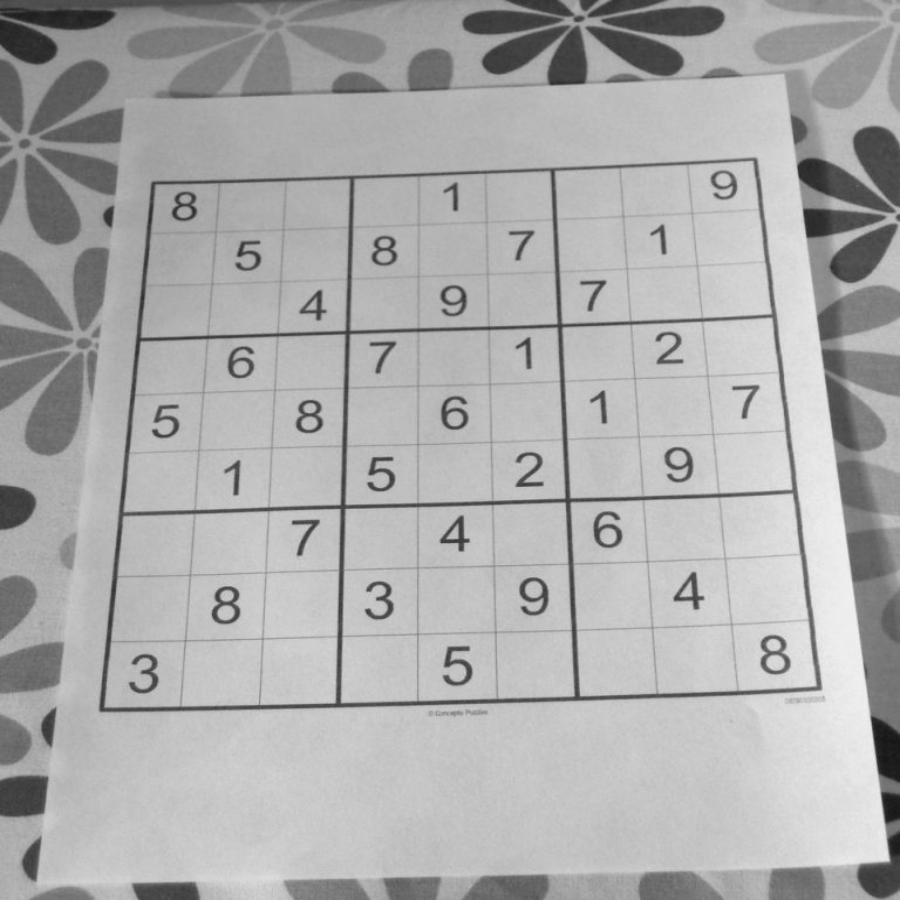

(900, 900)


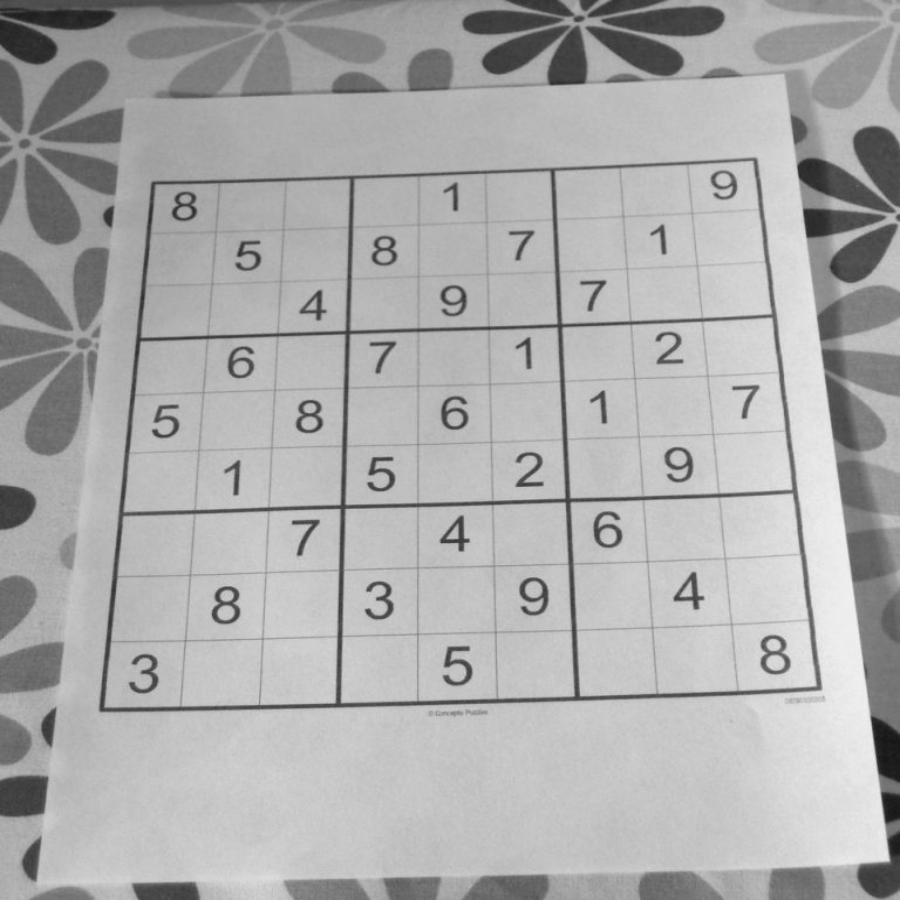

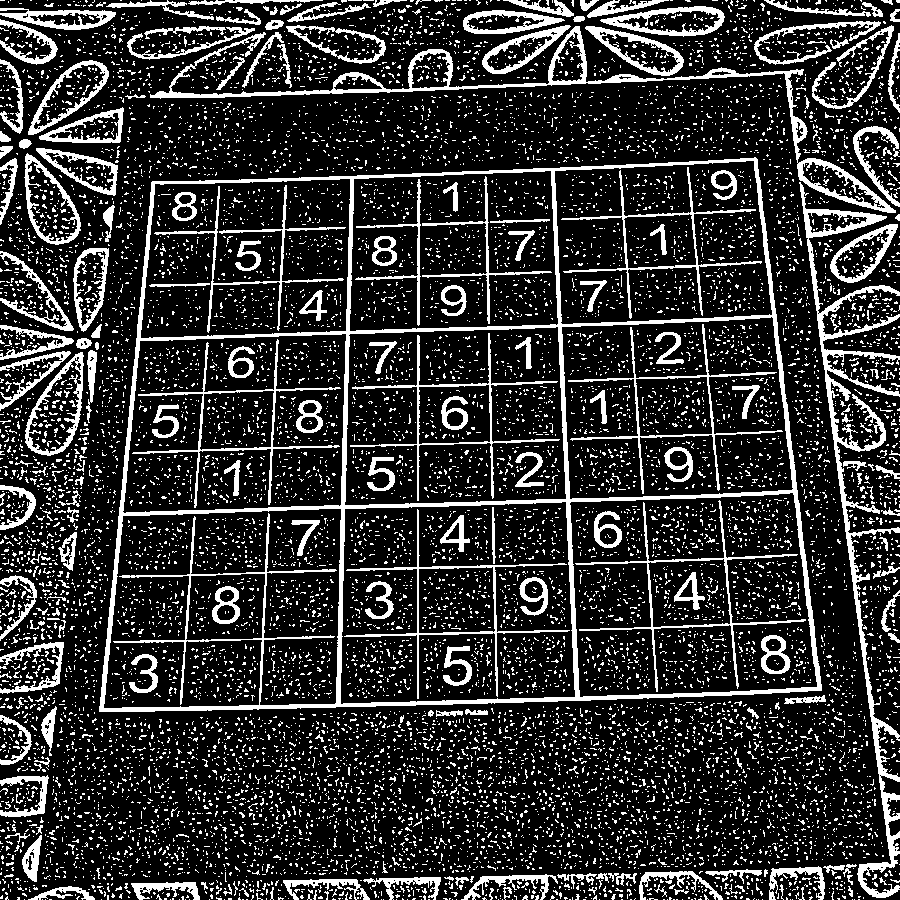

In [215]:
# 1. Read and preprocess
image = cv2.imread('sudoku3.jpg')
image = cv2.resize(image, (900, 900))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)
print(gray.shape)
blurred = cv2.GaussianBlur(gray, (1,1), 0)

cv2_imshow(blurred)

# 2. Threshold to get binary image
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
cv2_imshow(thresh)

* We are intersested in numbers it don't need information of color. So convert to gray.
* Blurring of image helps us to do better Adptive thresholding.

In [216]:
# 3. Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Number of contours found: {len(contours)}")

Number of contours found: 7299


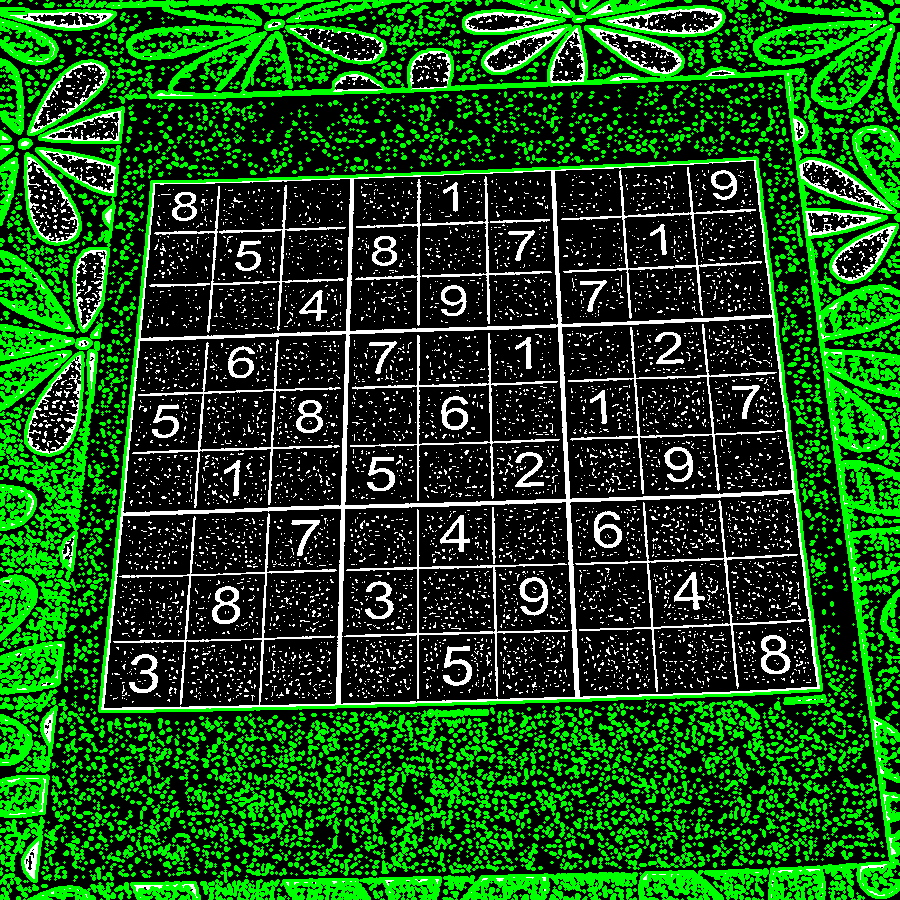

In [217]:

# Create a copy of the threshold image to draw on
contour_visualization = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

# Draw ALL contours in green
cv2.drawContours(contour_visualization, contours, -1, (0, 255, 0), 2)

# # Also draw each contour point as a red dot
# for i, contour in enumerate(contours):
#     print(f"Contour {i} has {len(contour)} points")
#     for point in contour:
#         x, y = point[0]
#         cv2.circle(contour_visualization, (x, y), 3, (0, 0, 255), -1)  # Red dots

cv2_imshow(contour_visualization)

Largest Contour has 373 points


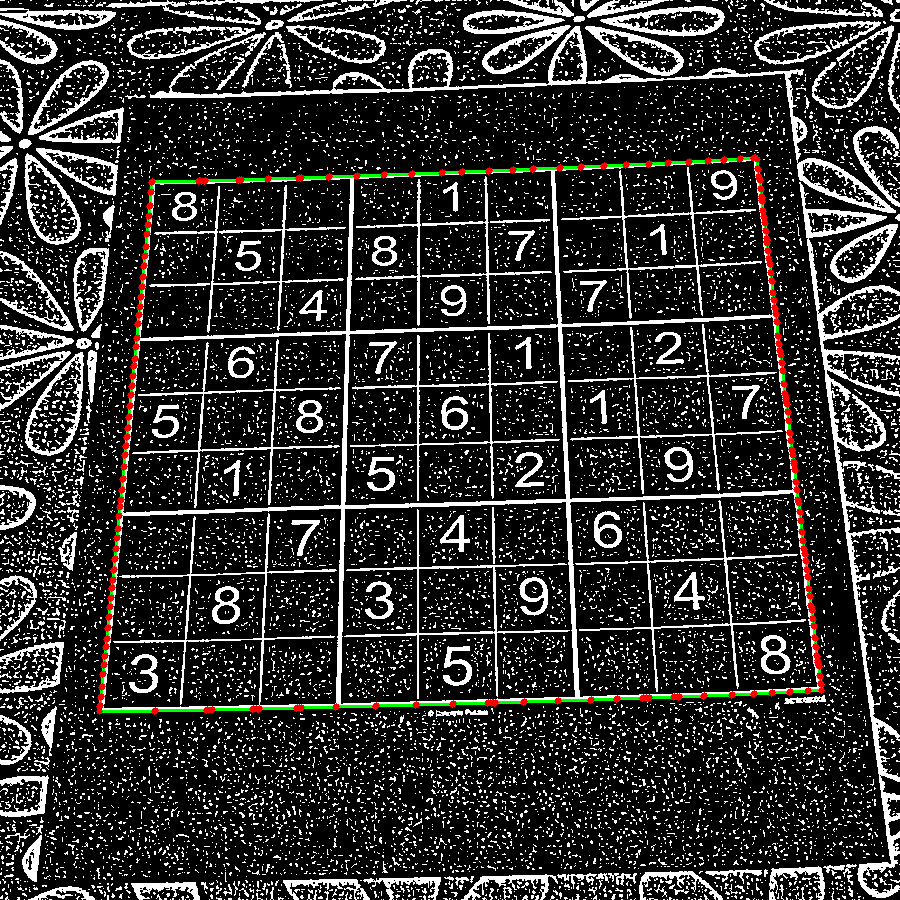

In [218]:
# 4. Find largest contour (Sudoku grid)
largest_contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]


# Create a copy of the threshold image to draw on
contour_visualization = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

# Draw ALL contours in green
cv2.drawContours(contour_visualization, [largest_contour], -1, (0, 255, 0), 2)

# # Also draw each contour point as a red dot
# for i, contour in enumerate(largest_contour):
print(f"Largest Contour has {len(largest_contour)} points")
for point in largest_contour:
    x, y = point[0]
    cv2.circle(contour_visualization, (x, y), 3, (0, 0, 255), -1)  # Red dots

cv2_imshow(contour_visualization)

After approximation: 4 points


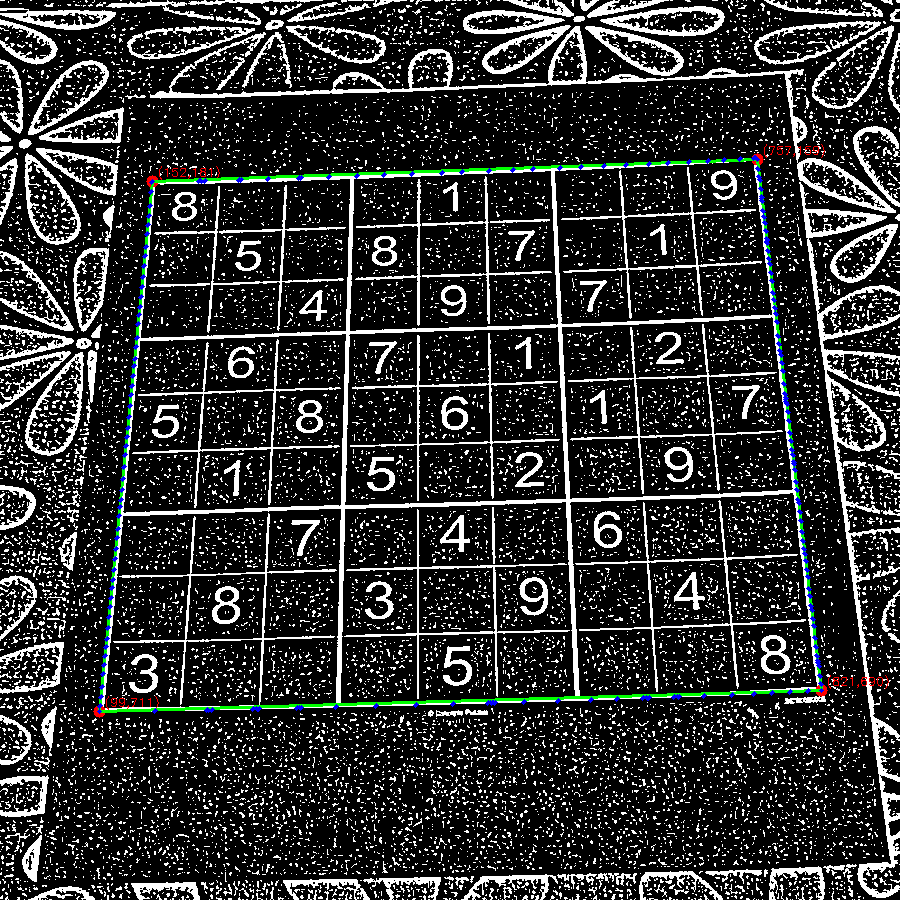

In [219]:
# 5. Approximate to quadrilateral
peri = cv2.arcLength(largest_contour, True)
approx = cv2.approxPolyDP(largest_contour, 0.02 * peri, True)

print(f"After approximation: {len(approx)} points")

# Create visualization
visualization = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

# Draw approximated contour points in red (larger)
for point in approx:
    x, y = point[0]
    cv2.circle(visualization, (x, y), 6, (0, 0, 255), -1)  # Red dots
    cv2.putText(visualization, f"({x},{y})", (x+5, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)

# Draw the approximated shape
cv2.drawContours(visualization, [approx], -1, (0, 255, 0), 2)

# Draw original contour points in blue
for point in largest_contour:
    x, y = point[0]
    cv2.circle(visualization, (x, y), 2, (255, 0, 0), -1)  # Blue dots

cv2_imshow(visualization)

* The Solution: four_point_transform warps the image to create a "bird's eye view" where the Sudoku grid appears perfectly rectangular and front-facing.


* Approximates a contour to a simpler shape with fewer vertices using the Douglas-Peucker algorithm

* It takes an input image and the four corner points of the region to be transformed.
* It calculates a perspective transformation matrix based on these four input points and a set of corresponding destination points (typically forming a perfect rectangle).
* It then applies this transformation matrix to the input image, producing a new image where the specified four-point region is now a rectangular, top-down view.

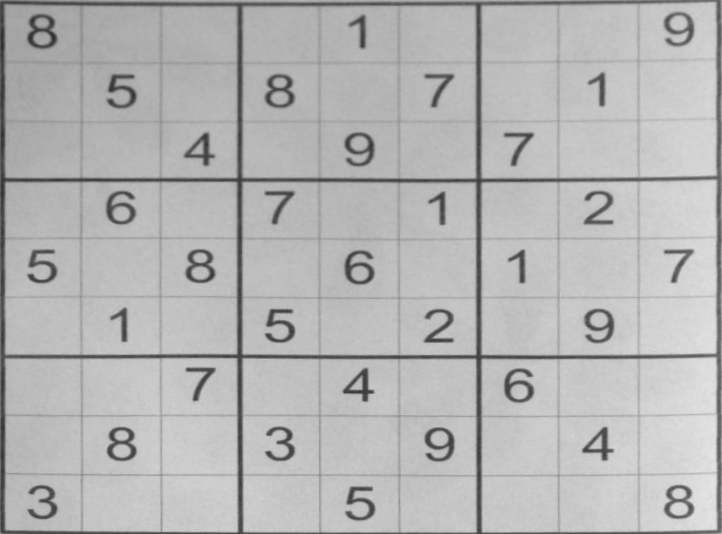

In [220]:
# Change the perspective of image to only sudoku grid
img = four_point_transform(image, approx.reshape(4, 2))
gray = four_point_transform(gray, approx.reshape(4, 2))
cv2_imshow(gray)

In [221]:
# Finds the digit component in the image
def connected(gray):
    blurred = cv2.GaussianBlur(gray,(7,7),3)
    (T,thresh) = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    output = cv2.connectedComponentsWithStats(thresh,4,cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    for i in range(numLabels):
        x = stats[i,0]
        y = stats[i,1]
        w = stats[i,2]
        h = stats[i,3]
        area = stats[i,4]
        (cX,cY) = centroids[i]
        if(w==0 and h==0):
            continue

        # Handpicked these values for getting digits
        keepWidth = w > 7 and w < 25
        keepHeight = h > 14 and h < 28
        keepArea = area > 100 and area < 375
        keepAspectRatio = 0.3 <= (w/h) <= 1.2  # NEW: Aspect ratio check
        if((keepWidth & keepHeight & keepAspectRatio)):
            component = np.zeros(gray.shape,dtype='uint8')
            component[y:y+h,x:x+w] = gray[y:y+h,x:x+w]
            return component
    return None

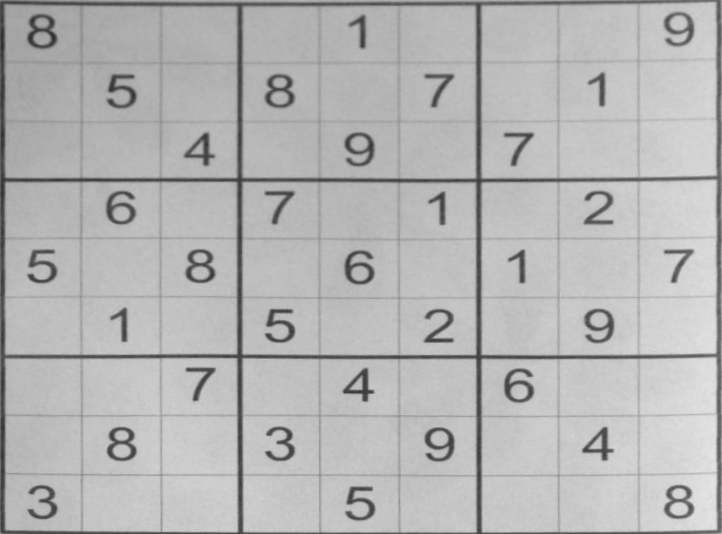

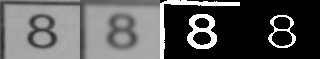

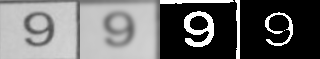

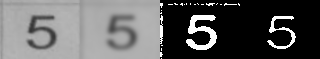

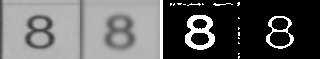

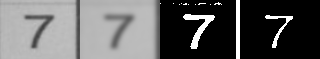

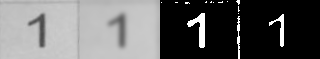

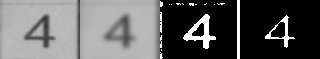

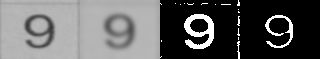

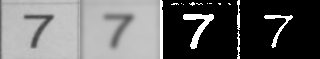

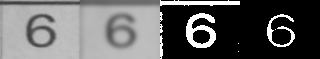

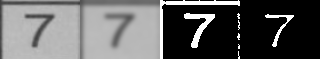

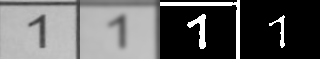

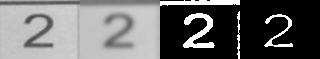

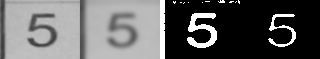

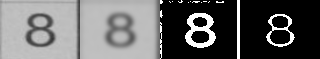

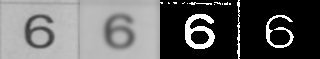

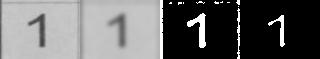

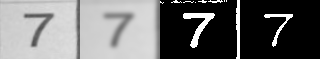

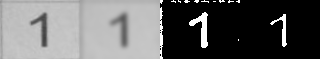

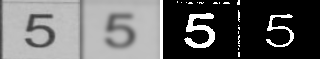

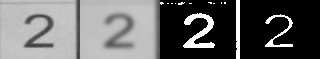

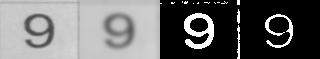

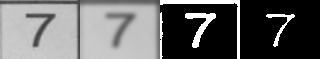

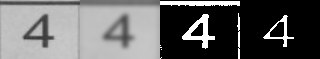

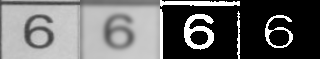

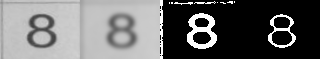

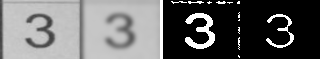

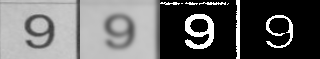

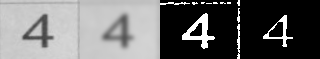

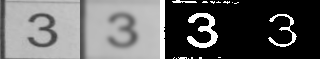

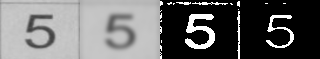

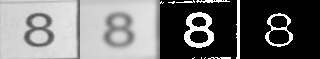

In [222]:
import numpy as np
(h,w) = gray.shape[:2]
height = h//9
width = w//9

matrix = np.zeros((9,9),dtype='int')
cv2_imshow(gray)
# Get each digit in image
for i in range(9):
    for j in range(9):
        x = j*width
        y = i*height
        roi = gray[y:y+height,x:x+width]

        blurred = cv2.GaussianBlur(roi,(11,11),2)

        thresh = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        thresh_no_border = clear_border(thresh)

        #Do Erosion - make digits thinner
        kernel = np.ones((3,3),np.uint8)
        thresh_no_border = cv2.erode(thresh_no_border,kernel,iterations = 1)

        input_digit = cv2.resize(thresh_no_border,(28,28))
        component = connected(input_digit)
        if component is None:
            continue

        cv2_imshow(np.hstack([roi,blurred,thresh,thresh_no_border]))


### Load Model

In [223]:

def transform_image(image):
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)  # Add channel dimension
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = torch.tensor(image).to(device)
    return image

def predict_digit(image):
    image = transform_image(image)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
    return classes[predicted.item()]

classes = [0,1,2,3,4,5,6,7,8,9]
model = DigitRecognizer(width=28, height=28, depth=1, classes=10)

checkpoint = torch.load('model.pth', map_location=torch.device('cpu'))
print(type(checkpoint))
print(checkpoint.keys() if isinstance(checkpoint['model_state_dict'], dict) else "Not a dictionary")


model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


classes = [0,1,2,3,4,5,6,7,8,9]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
transform = torch.nn.functional.normalize
print(f"[INFO] Using device: {device}")


<class 'dict'>
dict_keys(['model_state_dict', 'optimizer_state_dict'])
[INFO] Using device: cuda


### Backtrack solution given matrix

In [224]:

def is_valid(matrix,i,j,val):
    #Check whether we can place matrix[i,j] = val
    for k in range(9):
        if matrix[i][k]==val or matrix[k][j]==val:
            return False

        box_row_start = 3*(i//3)
        box_col_start = 3*(j//3)

        if matrix[box_row_start + (k//3)][box_col_start + (k%3)] == val:
            return False

    return True

def solve(matrix,i,j):
    #Find the solution to the sudoku grid using backtracking
    if(i==9):
        return (matrix,True)
    elif j == 9:
        return solve(matrix,i+1,0)

    if matrix[i][j] == 0:
        #check for all possible values from 1 to 9 at [i,j]
        for val in range(1,10):
            #Is it valid to place val at [i,j]
            if is_valid(matrix,i,j,val):
                matrix[i][j] = val
                output,flag = solve(matrix,i,j+1)
                if flag:
                    return (output,True)
                matrix[i][j] = 0
        #No valid value found, return False
        return (matrix,False)
    else:
        return solve(matrix,i,j+1)



### Is valid Sudoku matrix

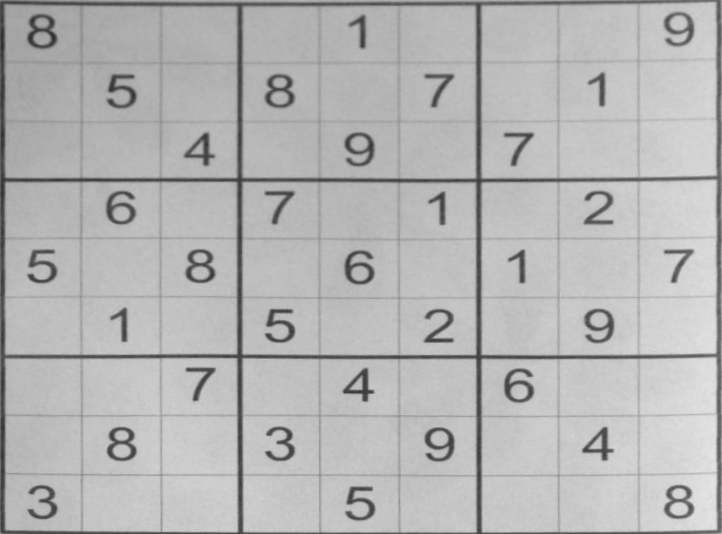

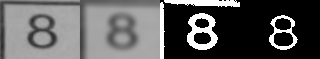

0 0 tensor([8], device='cuda:0')


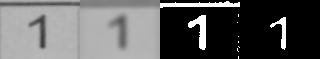

0 4 tensor([1], device='cuda:0')


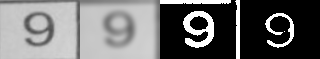

0 8 tensor([9], device='cuda:0')


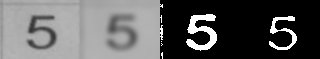

1 1 tensor([5], device='cuda:0')


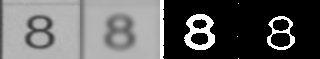

1 3 tensor([8], device='cuda:0')


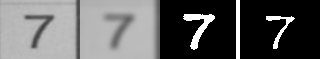

1 5 tensor([7], device='cuda:0')


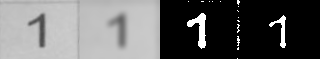

1 7 tensor([1], device='cuda:0')


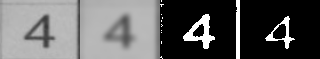

2 2 tensor([4], device='cuda:0')


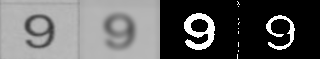

2 4 tensor([9], device='cuda:0')


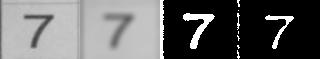

2 6 tensor([7], device='cuda:0')


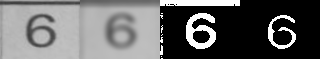

3 1 tensor([6], device='cuda:0')


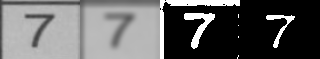

3 3 tensor([7], device='cuda:0')


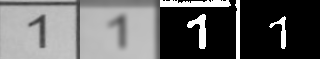

3 5 tensor([1], device='cuda:0')


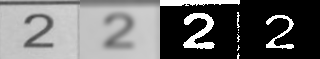

3 7 tensor([2], device='cuda:0')


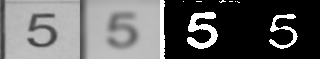

4 0 tensor([5], device='cuda:0')


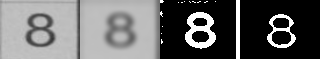

4 2 tensor([8], device='cuda:0')


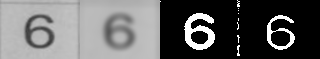

4 4 tensor([6], device='cuda:0')


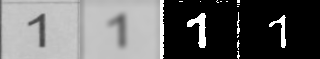

4 6 tensor([1], device='cuda:0')


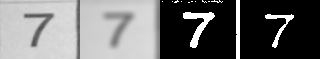

4 8 tensor([7], device='cuda:0')


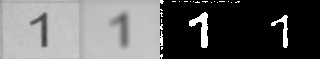

5 1 tensor([1], device='cuda:0')


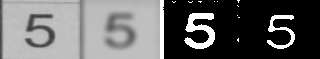

5 3 tensor([5], device='cuda:0')


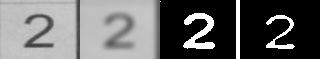

5 5 tensor([2], device='cuda:0')


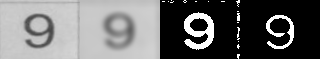

5 7 tensor([9], device='cuda:0')


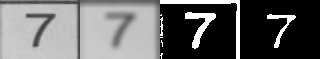

6 2 tensor([7], device='cuda:0')


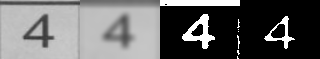

6 4 tensor([4], device='cuda:0')


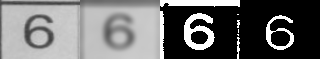

6 6 tensor([6], device='cuda:0')


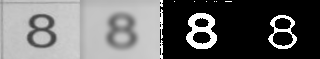

7 1 tensor([8], device='cuda:0')


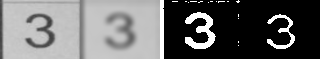

7 3 tensor([3], device='cuda:0')


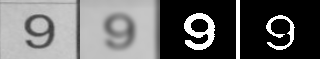

7 5 tensor([9], device='cuda:0')


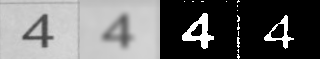

7 7 tensor([4], device='cuda:0')


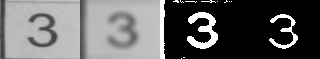

8 0 tensor([3], device='cuda:0')


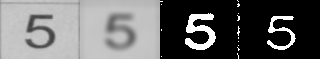

8 4 tensor([5], device='cuda:0')


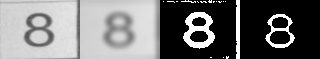

8 8 tensor([8], device='cuda:0')


In [225]:

# Get the height and width of the transformed gray image
(h,w) = gray.shape[:2]
height = h//9
width = w//9

cv2_imshow(gray)

matrix = np.zeros((9,9),dtype='int')

# Get each digit in image
for i in range(9):
    for j in range(9):
        x = j*width
        y = i*height
        roi = gray[y:y+height,x:x+width]

        blurred = cv2.GaussianBlur(roi,(9,9),3)

        thresh = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        thresh_no_border = clear_border(thresh)

        #Do Erosion - make digits thinner
        kernel = np.ones((2,2),np.uint8)
        thresh_no_border = cv2.erode(thresh_no_border,kernel,iterations = 2)

        input_digit = cv2.resize(thresh_no_border,(28,28))
        component = connected(input_digit)
        if component is None:
            continue

        cv2_imshow(np.hstack([roi,blurred,thresh,thresh_no_border]))

        roi = component.astype("float") / 255.0
        roi = np.array(roi).reshape((1,28,28))
        roi = np.expand_dims(roi, axis=0)
        roi = torch.FloatTensor(roi)
        roi = roi.to(device)
        #print(roi.shape)
        pred = model.predict(roi)

        print(i,j,pred)
        matrix[i,j] = pred[0]
        cv2.waitKey(0)
    cv2.destroyAllWindows()


In [226]:
print(matrix)

[[8 0 0 0 1 0 0 0 9]
 [0 5 0 8 0 7 0 1 0]
 [0 0 4 0 9 0 7 0 0]
 [0 6 0 7 0 1 0 2 0]
 [5 0 8 0 6 0 1 0 7]
 [0 1 0 5 0 2 0 9 0]
 [0 0 7 0 4 0 6 0 0]
 [0 8 0 3 0 9 0 4 0]
 [3 0 0 0 5 0 0 0 8]]


In [227]:
def is_valid_sudoku(matrix):
    """
    Handles various input formats including strings and dots for empty cells.
    """
    rows = [set() for _ in range(9)]
    cols = [set() for _ in range(9)]
    boxes = [set() for _ in range(9)]

    for i in range(9):
        for j in range(9):
            num = matrix[i][j]

            # Handle different empty cell representations
            if num in [0, '.', '']:
                continue

            # Convert to integer
            try:
                num = int(num)
            except (ValueError, TypeError):
                continue

            # Validate number range
            if num < 1 or num > 9:
                return False

            # Check duplicates
            box_idx = (i // 3) * 3 + (j // 3)

            if num in rows[i] or num in cols[j] or num in boxes[box_idx]:
                return False

            rows[i].add(num)
            cols[j].add(num)
            boxes[box_idx].add(num)

    return True

Sudoku :
[[8 0 0 0 1 0 0 0 9]
 [0 5 0 8 0 7 0 1 0]
 [0 0 4 0 9 0 7 0 0]
 [0 6 0 7 0 1 0 2 0]
 [5 0 8 0 6 0 1 0 7]
 [0 1 0 5 0 2 0 9 0]
 [0 0 7 0 4 0 6 0 0]
 [0 8 0 3 0 9 0 4 0]
 [3 0 0 0 5 0 0 0 8]]
Sudoku_grid


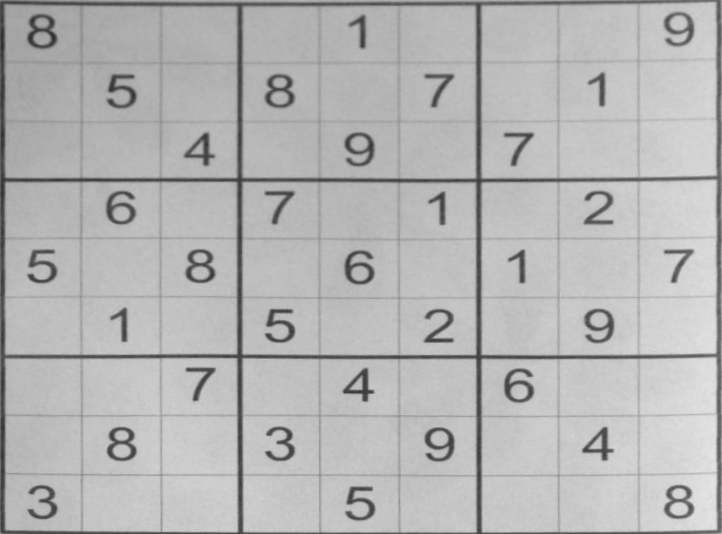

Sudoku_Solved : 
[[8 7 2 4 1 3 5 6 9]
 [9 5 6 8 2 7 3 1 4]
 [1 3 4 6 9 5 7 8 2]
 [4 6 9 7 3 1 8 2 5]
 [5 2 8 9 6 4 1 3 7]
 [7 1 3 5 8 2 4 9 6]
 [2 9 7 1 4 8 6 5 3]
 [6 8 5 3 7 9 2 4 1]
 [3 4 1 2 5 6 9 7 8]]
Sudoku_solved


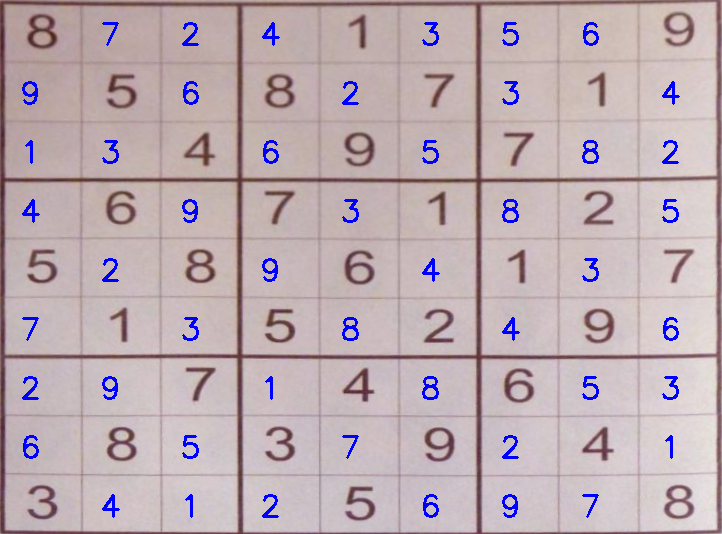

In [228]:
print("Sudoku :")
print(matrix)

valid_matrix = is_valid_sudoku(matrix)

if not valid_matrix:
    print("Sudoku is not valid")
    print("Something is wrong in detecting numbers !")
    print("Give better image....!")
else:
    print("Sudoku_grid")
    cv2_imshow(gray)
    (sol,flag) = solve(matrix.copy(),0,0)
    print("Sudoku_Solved : ")
    print(sol)

    # Fill the sudoku grid with answer
    for i in range(9):
        for j in range(9):
            if(matrix[i][j]!=0):
                continue
            x = j*width
            y = i*height
            cv2.putText(img, str(sol[i][j]), (x+width//4, y+3*height//4),cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)  # Changed to (0, 0, 0) - BLACK
    print("Sudoku_solved")
    cv2_imshow(img)
    cv2.imwrite("sudoku_solved.png",img)

* Improvement Check with Dilation of test image before predication.
* Train with binary mnist dataset.
* Check with clustering algo then model for individual clusters